# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d100/2f0bb04162655f0cba429b865292f31482e817e0b3ee9da0f40185d7.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Islington, Islington, United Kingdom**, and the stations the data comes from are shown on the map below.

In [2]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(100,'2f0bb04162655f0cba429b865292f31482e817e0b3ee9da0f40185d7')

In [3]:
# pull data
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d100/2f0bb04162655f0cba429b865292f31482e817e0b3ee9da0f40185d7.csv')
# interpreting "record high" as the max value of all selected stations wrt to their daily max temperature
tmax = df[df['Element']=='TMAX'].sort('Date').groupby('Date').max()
# interpreting "record low" as the min value of all selected stations wrt to their daily min temperature
tmin = df[df['Element']=='TMIN'].sort('Date').groupby('Date').min()
# turn indices into datetime format
tmax.index = tmax.index.to_datetime()
tmin.index = tmin.index.to_datetime()

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


In [4]:
# produce day of the year data to get high and low records for 2005-2014
start_date = '2005-01-01'
end_date = '2014-12-31'
# select date range
tmax1 = tmax[start_date:end_date]
tmin1 = tmin[start_date:end_date]
# group by month and day to aggregate years
tmax1 = tmax1.groupby([tmax1.index.month, tmax1.index.day]).max()
tmin1 = tmin1.groupby([tmin1.index.month, tmin1.index.day]).min()
# drop 29-Feb
tmax1.drop([(2,29)], inplace=True)
tmin1.drop([(2,29)], inplace=True)

In [5]:
# produce new records from 2015
start_date = '2015-01-01'
end_date = '2015-12-31'
# select date range
tmax2 = tmax[start_date:end_date]
tmin2 = tmin[start_date:end_date]
# group by month and day to align with format for 2005-2014 data
tmax2 = tmax2.groupby([tmax2.index.month, tmax2.index.day]).sum()
tmin2 = tmin2.groupby([tmin2.index.month, tmin2.index.day]).sum()

In [6]:
# import numpy for np.nan
import numpy as np
# join 2005-2014 and 2015 data in one df
tmax3 = tmax1.join(tmax2, how='inner', lsuffix='_2005-14', rsuffix='_2015')
tmin3 = tmin1.join(tmin2, how='inner', lsuffix='_2005-14', rsuffix='_2015')
# override as NaN where there is no new record in 2015
tmax3[tmax3['Data_Value_2015'] <= tmax3['Data_Value_2005-14']] = np.nan
tmin3[tmin3['Data_Value_2015'] >= tmin3['Data_Value_2005-14']] = np.nan

In [7]:
# generate x-axis dates
observation_dates = pd.date_range('2015-01-01', '2015-12-31')

In [8]:
# plot data
x = observation_dates
y1 = tmax1['Data_Value'].values/10
y2 = tmin1['Data_Value'].values/10
y3 = tmax3['Data_Value_2015'].values/10
y4 = tmin3['Data_Value_2015'].values/10

In [9]:
# plot setup
%matplotlib notebook
plt.rcParams['font.sans-serif'] = "Helvetica"

<IPython.core.display.Javascript object>


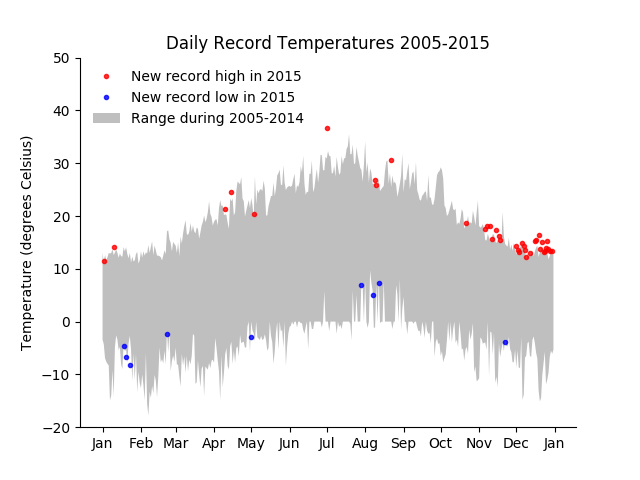

In [10]:
# plot 
fig, ax = plt.subplots()
# adjust y-axis range to fit the legend without data overlap
ax.set_ylim([-20,50])
# set title and y-axis label (x-axis not required)
plt.title('Daily Record Temperatures 2005-2015')
ax.set_ylabel('Temperature (degrees Celsius)')
# hide frame
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# fill between y1 and y2 and plot the new records as points
ax.fill_between(x, y1, y2, facecolor='grey', alpha=0.5, label='Range during 2005-2014')
ax.plot(x, y3, 'r.', alpha=0.8, label='New record high in 2015')
ax.plot(x, y4, 'b.', alpha=0.8, label='New record low in 2015')
# add legend w/o frame
legend = ax.legend(loc='upper left', frameon=False)
# format the x-axis datetime to three letter months and ticks at the beginning of the month
import matplotlib.dates as mdates
yearsFmt = mdates.DateFormatter('%b')
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)

In [14]:
# save image as jpg
fig.savefig('daily_record_temperatures_2005-2015.jpg', format='jpg')

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [ ]:
# To reduce ink, I decided to plot only the shaded area between the two lines as it accurately represents the range of record low to high temperatures each day of the year. I used grey as a colour for the range as it is the basic data and does not need to stand out. To indicate the new records in 2015, I used red (hot) for high records and blue (cold) for low records, where the choice of colour naturally emphasises the difference between a record on the high and low end. I used point markers to keep it simple and removed the top and right frame. The x-axis displays only the first three letters of every month to improve readability and reduce ink. No further label of the x-axis is required as its meaning can be sufficiently inferred from the title and the tick labels (months). I transposed the 10th of a degree data into the more familiar scale of full ticks. No gridlines or data labels are required as we're looking for trends and patterns rather than absolute values of the data. Hence, the y-axis can also comfortably be labeled in steps of 10 between ticks.  The legend has no frame to reduce non-data ink. Changed font to Helvetica for a more pleasant feel. No background colour was used as it provides no further information.